# Call graph analysis

In [138]:
import networkx as nx
from networkx.drawing.nx_agraph import read_dot, graphviz_layout
import matplotlib.pyplot as plt

import graphs

In [139]:
# Sample dot files for testing
dot_files2 = [
    "/Users/christopher/Uni/MasterThesis/repositories/masters-thesis/profiles/unionInplaceOut2.dot",
    "/Users/christopher/Uni/MasterThesis/repositories/masters-thesis/profiles/unserReadFrom2.dot"
]

In [1]:
# Sample dot files for testing
dot_files = [
    "/Users/christopher/Uni/MasterThesis/repositories/masters-thesis/profiles/unionInplaceOut.dot",
    "/Users/christopher/Uni/MasterThesis/repositories/masters-thesis/profiles/unserReadFrom.dot"
]

In [140]:
def get_name_from_dot(path):
    # Remove last dot, remove last 3 "_" which are hardcoded
    return path.split("/")[-1].rsplit(".", 1)[0].rsplit("_", 3)[0]

In [141]:
"""Load and convert all graphs, and generate a unique node mapping."""
count_bad_input = 0
ordered_graphs = {}
none_perf_benchs = []
removed_node_name = set()
for dot_file in dot_files2:
    name = get_name_from_dot(dot_file)

    if "BenchmarkSize" in name or "BenchmarkMemory" in name:
        none_perf_benchs.append(name)
        continue
    
    try:
        curr_graph = read_dot(dot_file)
        curr_graph = graphs.convertWeigthsToFloat(curr_graph)
    except ValueError: 
        count_bad_input += 1
        print(dot_file.split("/")[-1])
        continue
    
    # Check if one of the nodes includes 'runActualBenchmark, if yes create a subgraph starting at that node
    for node in curr_graph.nodes(data=True):
        if 'ActualBenchmark' in node[1]['label']:
            print(f"Found {node[1]['label']}")
        break

    # Removing starting nodes like file, type etc.
    try:
        name_first_node = list(curr_graph.nodes(data=True))[0][0]
        if name_first_node != "N1":
            removed_node_name.add(name_first_node)
            curr_graph.remove_node(name_first_node)
    except Exception as e:
        print(e)

    # Add all graphs from the same benchmark together and later form the union
    try: 
        ordered_graphs[name].append(curr_graph)
    except KeyError:
       ordered_graphs[name] = []
       ordered_graphs[name].append(curr_graph)


print(f"Bad input: {count_bad_input}")
print(f"None perf benchmarks: {none_perf_benchs}")
print(f"Removed node names: {removed_node_name}")

Bad input: 0
None perf benchmarks: []
Removed node names: {'Type: cpu'}


In [142]:
ordered_graphs

{'unionInplaceOut2': [<networkx.classes.multidigraph.MultiDiGraph at 0x133ac5310>],
 'unserReadFrom2': [<networkx.classes.multidigraph.MultiDiGraph at 0x133afd850>]}

In [143]:
all_graphs = [val for sublist in ordered_graphs.values() for val in sublist]
nameMappingFull = graphs.generateUniqueNodeMapping(all_graphs)

In [144]:
final_graphs = []
for keys in ordered_graphs.keys():
    
    if len(ordered_graphs[keys]) != 2:
        print(keys, len(ordered_graphs[keys]))

    union_graphs = []
    for graph in ordered_graphs[keys]:
        mapping = graphs.getNodeNameMapping(graph)
        
        nodeMapping = {}
        # get node name by value
        for key in mapping:
            nodeMapping[key] = nameMappingFull[mapping[key]]

        union_graphs.append(nx.relabel_nodes(graph, nodeMapping))

    final_graphs.append(nx.compose_all(union_graphs))

unionInplaceOut2 1
unserReadFrom2 1


In [145]:
""" Generate full graph, position and labels."""
labeldict = {v: k for k, v in nameMappingFull.items()}
full_graph = nx.compose_all(final_graphs)
pos_full = graphviz_layout(full_graph, prog='dot')

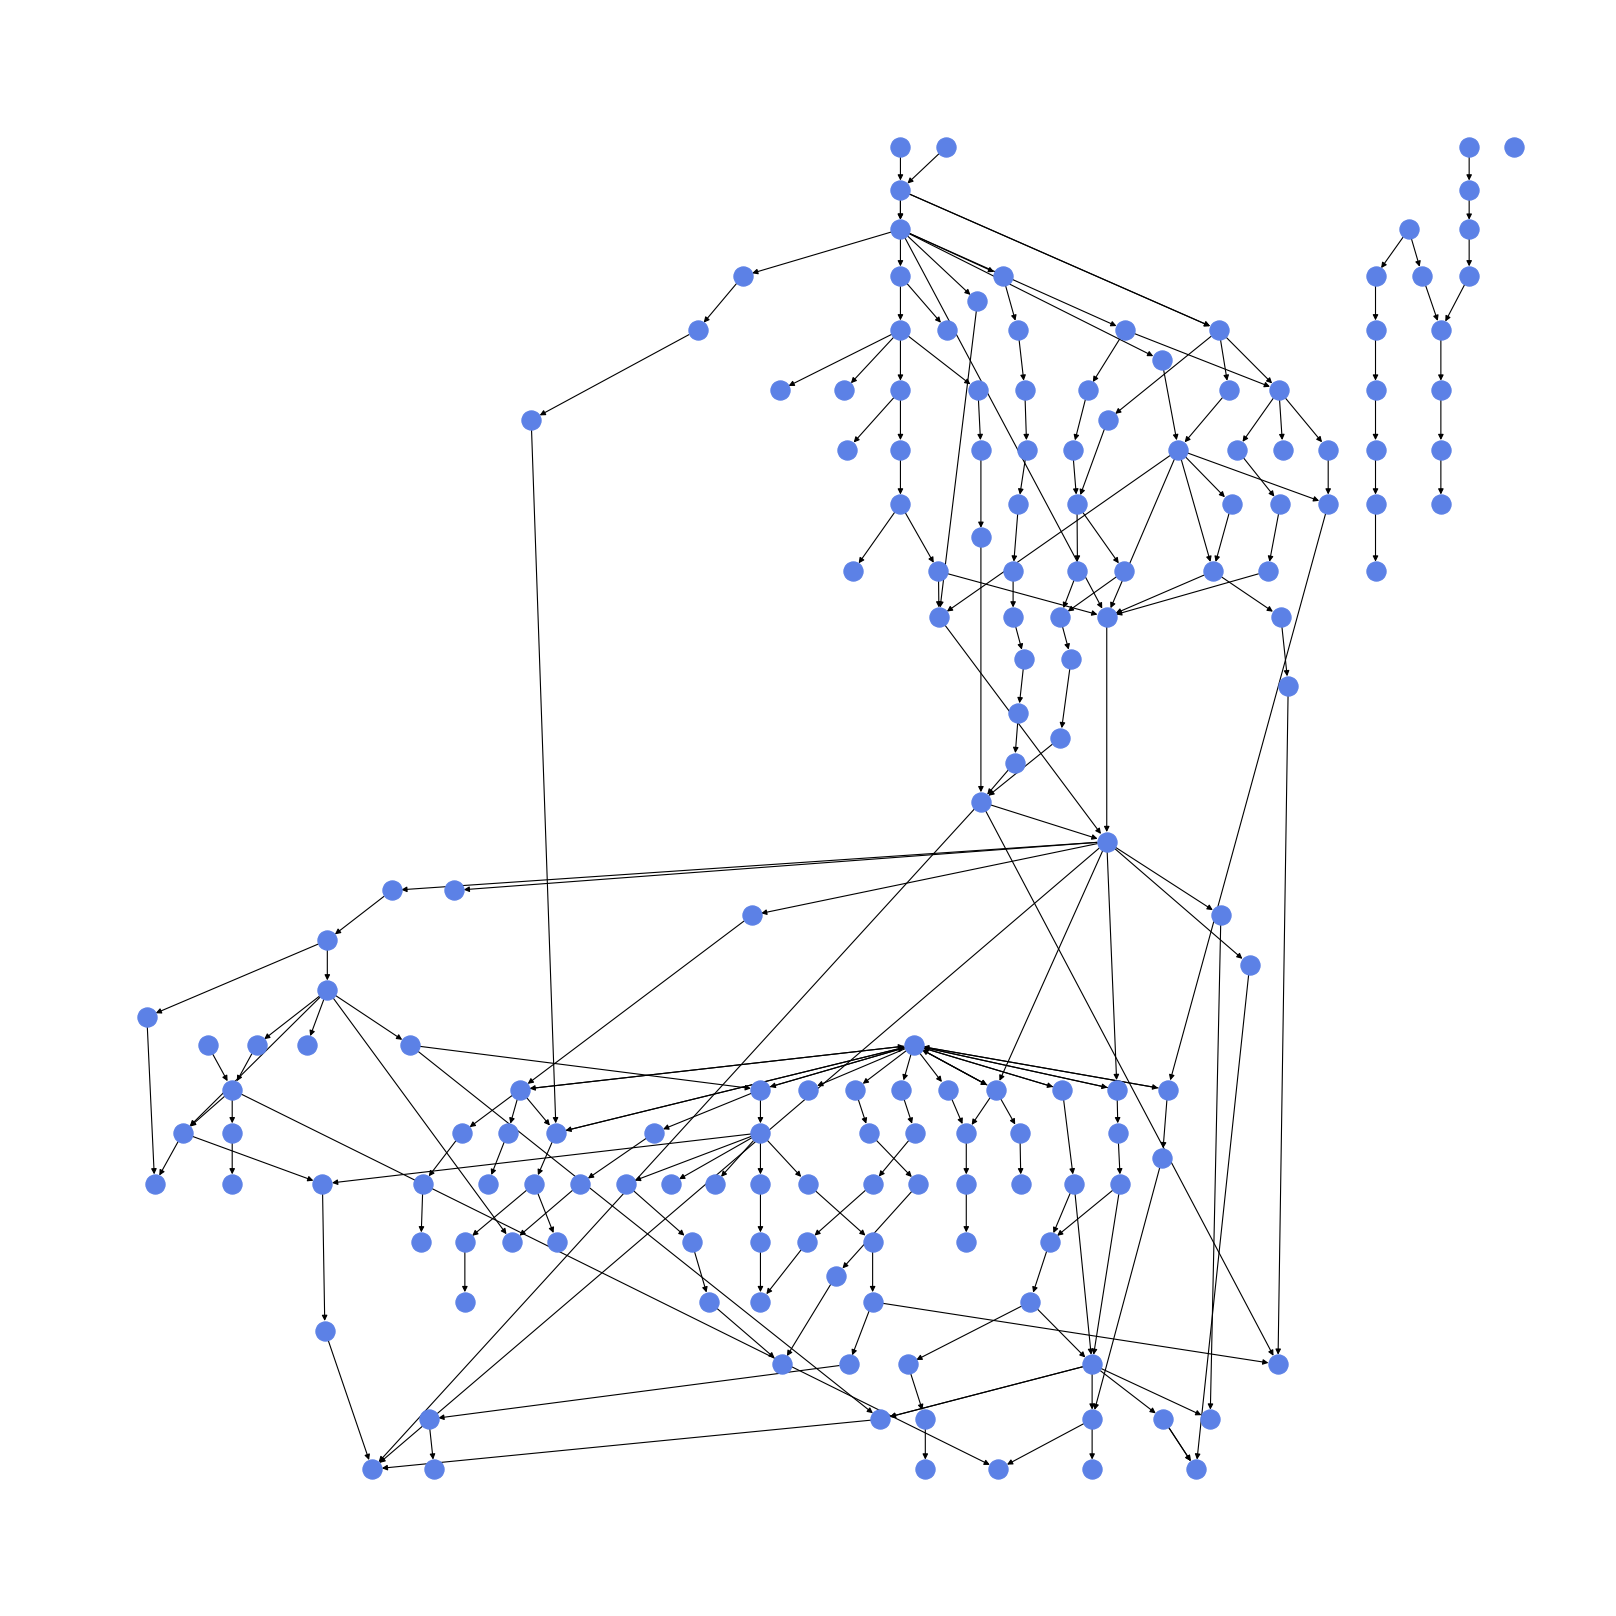

In [146]:
plt.figure(figsize=(20, 20), dpi=80)
nx.draw(full_graph, pos_full, arrows=True, node_color="#5c81e6")
plt.show()

# Single Graph

In [147]:
curr_graph = read_dot(dot_files[1])
curr_graph = graphs.convertWeigthsToFloat(curr_graph)

In [17]:
curr_graph.nodes(data=True)

NodeDataView({'Type: cpu': {'fontsize': '16', 'label': 'Type: cpu\\lTime: Jul 12, 2023 at 11:59am (CEST)\\lDuration: 13.08s, Total samples = 11.84s (90.53%)\\lShowing nodes accounting for 11.84s, 100% of 11.84s total\\l\\lSee https://git.io/JfYMW for how to read the graph\\l', 'shape': 'box'}, 'N1': {'color': '#b20000', 'fillcolor': '#edd5d5', 'fontsize': '24', 'id': 'node1', 'label': 'runtime\\nkevent\\n11.70s (98.82%)', 'shape': 'box', 'tooltip': 'runtime.kevent (11.70s)'}, 'N2': {'color': '#b20000', 'fillcolor': '#edd5d5', 'fontsize': '8', 'id': 'node2', 'label': 'runtime\\nsystemstack\\n0 of 11.72s (98.99%)', 'shape': 'box', 'tooltip': 'runtime.systemstack (11.72s)'}, 'N3': {'color': '#b20000', 'fillcolor': '#edd5d5', 'fontsize': '8', 'id': 'node3', 'label': 'runtime\\nstartTheWorldWithSema\\n0 of 11.70s (98.82%)', 'shape': 'box', 'tooltip': 'runtime.startTheWorldWithSema (11.70s)'}, 'N4': {'color': '#b2b0aa', 'fillcolor': '#edecec', 'fontsize': '8', 'id': 'node4', 'label': 'testin

In [148]:
list(curr_graph.nodes(data=True))[2]

('N2',
 {'color': '#b20000',
  'fillcolor': '#edd5d5',
  'fontsize': '8',
  'id': 'node2',
  'label': 'runtime\\nsystemstack\\n0 of 11.72s (98.99%)',
  'shape': 'box',
  'tooltip': 'runtime.systemstack (11.72s)'})

In [149]:
list(final_graphs[1].nodes(data=True))[2]

('N130',
 {'color': '#b20000',
  'fillcolor': '#edd5d5',
  'fontsize': '8',
  'id': 'node3',
  'label': 'runtime\\nstartTheWorldWithSema\\n0 of 11.70s (98.82%)',
  'shape': 'box',
  'tooltip': 'runtime.startTheWorldWithSema (11.70s)'})

In [150]:
nodes_to_remove = []
test_graph1 = final_graphs[0].copy()
# Remove all runtime nodes
for node in final_graphs[0].nodes(data=True):
    if  node[1]['label'].startswith('roaring'):
       continue
    nodes_to_remove.append(node[0])
test_graph1.remove_nodes_from(nodes_to_remove)

In [151]:
nodes_to_remove = []
test_graph2 = final_graphs[1].copy()
# Remove all runtime nodes
for node in final_graphs[1].nodes(data=True):
    if  node[1]['label'].startswith('roaring'):
       continue
    nodes_to_remove.append(node[0])
test_graph2.remove_nodes_from(nodes_to_remove)

In [153]:
print(len(final_graphs[1].nodes(data=True)))
print(len(test_graph2.nodes(data=True)))

58
11


In [154]:
for node in test_graph2.nodes(data=True):
    print(node[1]['label'])

roaring\n(*Bitmap)\nAdd\n0.01s (0.084%)\nof 0.03s (0.25%)
roaring\n(*roaringArray)\nreadFrom\n0 of 0.06s (0.51%)
roaring\nBenchmarkUnserializeReadFrom\nfunc1\n0 of 0.06s (0.51%)
roaring\n(*Bitmap)\nReadFrom\n0 of 0.06s (0.51%)
roaring\n(*Bitmap)\nWriteTo\n0 of 0.01s (0.084%)
roaring\n(*arrayContainer)\niaddReturnMinimized\n0 of 0.01s (0.084%)
roaring\n(*arrayContainer)\ntoBitmapContainer\n0 of 0.01s (0.084%)
roaring\n(*bitmapContainer)\nwriteTo\n0 of 0.01s (0.084%)
roaring\n(*roaringArray)\nsetContainerAtIndex\n0 of 0.01s (0.084%)
roaring\n(*roaringArray)\nwriteTo\n0 of 0.01s (0.084%)
roaring\nnewBitmapContainer\n0 of 0.01s (0.084%)


In [155]:
labeldict1 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in test_graph1.nodes():
        del labeldict1[key]

In [156]:
labeldict2 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in test_graph2.nodes():
        del labeldict2[key]

In [157]:
# how to generate gradient color values based on percentage
colors2 = []
for node in list(test_graph2.nodes(data=True)):
    val = node[1]['label'].split("(")[-1].split("%)")[0]
    percentage = float(val) / 100
    color = (int(255 * percentage), int(255 * (1 - percentage)), 0)
    # convert to hex
    color = '#%02x%02x%02x' % color
    colors2.append(color)

In [158]:
# how to generate gradient color values based on percentage
colors1 = []
for node in list(test_graph1.nodes(data=True)):
    val = node[1]['label'].split("(")[-1].split("%)")[0]
    percentage = float(val) / 100
    color = (0, 0, int(255 * (1 - percentage)))
    # convert to hex
    color = '#%02x%02x%02x' % color
    colors1.append(color)

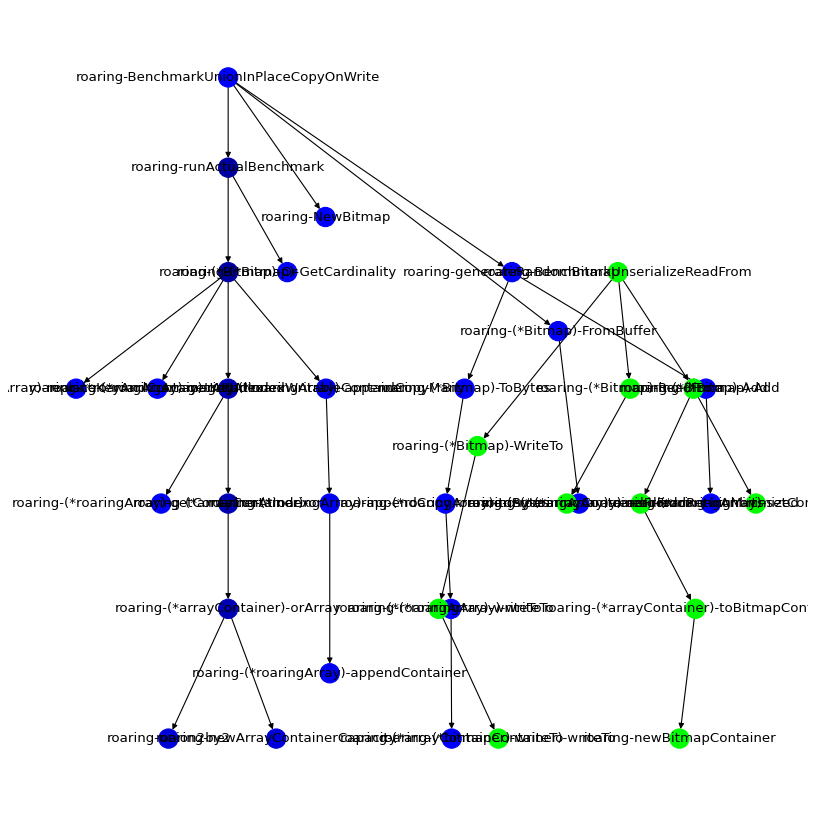

In [167]:
# plot graph with labels
plt.figure(figsize=(10, 10), dpi=80)

# shift pos full
pos_full2 = {k: (v[0] + 20, v[1]) for k, v in pos_full.items()}

nx.draw(test_graph1, pos_full2, arrows=True, node_color=colors1, labels=labeldict1)
nx.draw(test_graph2, pos_full, arrows=True, node_color=colors2, labels=labeldict2)
plt.show()

In [172]:
# get intersetion between the two test graphs
intersection = test_graph1.nodes() & test_graph2.nodes()

for node in test_graph.nodes(data=True):
    if node[0] in intersection:
        print(node)

('N78', {'color': '#b2b2b0', 'fillcolor': '#ededec', 'fontsize': '9', 'id': 'node7', 'label': 'roaring\\n(*Bitmap)\\nAdd\\n0.01s (0.084%)\\nof 0.03s (0.25%)', 'shape': 'box', 'tooltip': 'github.com/RoaringBitmap/roaring.(*Bitmap).Add (0.03s)'})
('N29', {'color': '#b2b1ad', 'fillcolor': '#ededec', 'fontsize': '8', 'id': 'node8', 'label': 'roaring\\n(*roaringArray)\\nreadFrom\\n0 of 0.06s (0.51%)', 'shape': 'box', 'tooltip': 'github.com/RoaringBitmap/roaring.(*roaringArray).readFrom (0.06s)'})
('N85', {'color': '#b2b2b1', 'fillcolor': '#ededed', 'fontsize': '8', 'id': 'node37', 'label': 'roaring\\n(*roaringArray)\\nwriteTo\\n0 of 0.01s (0.084%)', 'shape': 'box', 'tooltip': 'github.com/RoaringBitmap/roaring.(*roaringArray).writeTo (0.01s)'})


In [204]:
import re

def recalculate_percentages_based_on_seconds(graph):
    # extract seconds x.xxs using regex
    r = re.compile(r"(\d+\.\d+)s")

    total_time = 0
    for node in graph.nodes(data=True):
        seconds = r.search(node[1]['label']).group(1)
        total_time += float(seconds)

    # recalculate percentages
    for node in graph.nodes(data=True):
        seconds = float(r.search(node[1]['label']).group(1))
        # calculate percentage of total time
        percentage = seconds / total_time * 100
        node[1]['totalPerc'] = percentage

In [214]:
# check if first graph overlaps graph 2 sufficeintly
def calculate_overlap_value(graph1, graph2):

    # Calculate percentages based on total seconds of reduced graph
    recalculate_percentages_based_on_seconds(graph1)
    recalculate_percentages_based_on_seconds(graph2)

    perc = 0
    for node in graph2.nodes(data=True):
        if node[0] in graph1.nodes():
            print(f"Found {node[1]['label']} with {node[1]['totalPerc']}")
            perc += node[1]['totalPerc']
    return perc

In [215]:
calculate_overlap_value(test_graph1, test_graph2)

Found roaring\n(*Bitmap)\nAdd\n0.01s (0.084%)\nof 0.03s (0.25%) with 3.846153846153845
Found roaring\n(*roaringArray)\nreadFrom\n0 of 0.06s (0.51%) with 23.07692307692307
Found roaring\n(*roaringArray)\nwriteTo\n0 of 0.01s (0.084%) with 3.846153846153845


30.76923076923076

In [207]:
list(test_graph1.nodes(data=True))[0]

('N6',
 {'color': '#b23700',
  'fillcolor': '#eddcd5',
  'fontsize': '10',
  'id': 'node6',
  'label': 'roaring\\n(*arrayContainer)\\norArray\\n0.07s (0.49%)\\nof 4.18s (29.09%)',
  'shape': 'box',
  'tooltip': 'github.com/RoaringBitmap/roaring.(*arrayContainer).orArray (4.18s)',
  'totalPerc': 0.8706467661691546})